# Análise e Visualização do Modelo de Predição de Diabetes

Este notebook realiza a análise exploratória, visualização de dados e avaliação do modelo Random Forest treinado para diagnóstico de diabetes, utilizando o dataset Pima Indians Diabetes. Todas as etapas de análise, gráficos e explicações para TCC estão concentradas aqui.

## 1. Importação de Bibliotecas Necessárias

Importe as bibliotecas essenciais para análise de dados, visualização e machine learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

## 2. Carregamento e Visualização Inicial do Dataset

Vamos carregar o dataset Pima Indians Diabetes e visualizar suas primeiras linhas, além de informações básicas.

In [2]:
# Carregar o dataset
url = 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'
df = pd.read_csv(url)

print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas.")
df.head()

Dataset carregado: 768 linhas, 9 colunas.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 3. Análise Exploratória de Dados (EDA)

Vamos analisar a distribuição das classes, estatísticas descritivas e correlação entre variáveis.

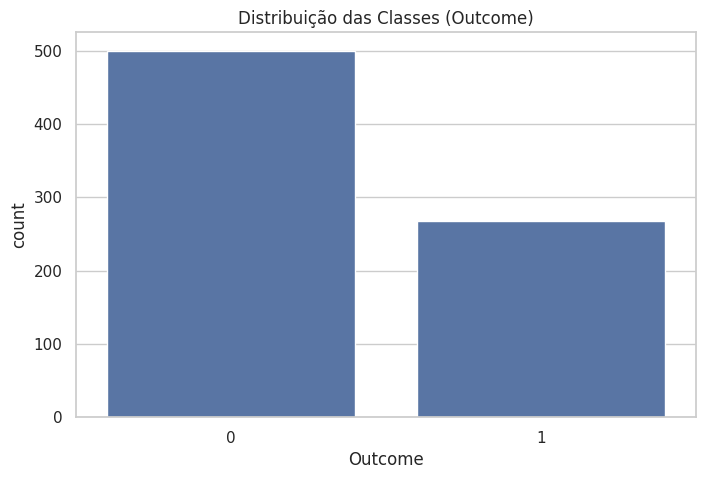

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

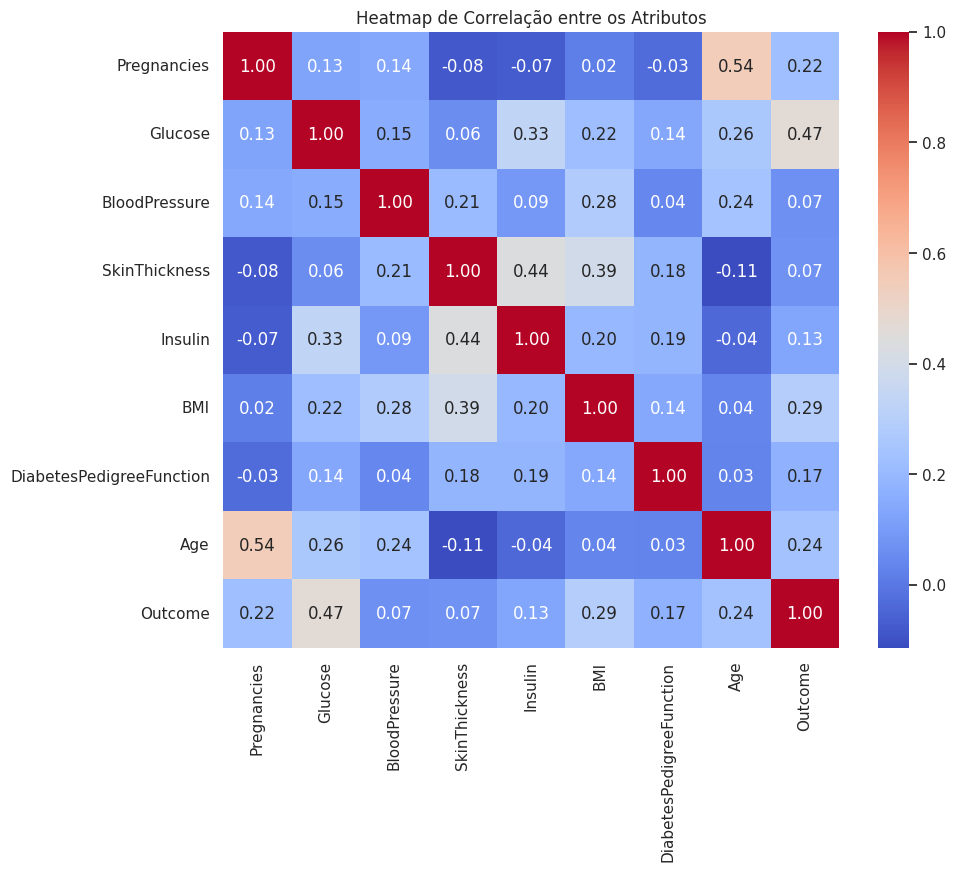

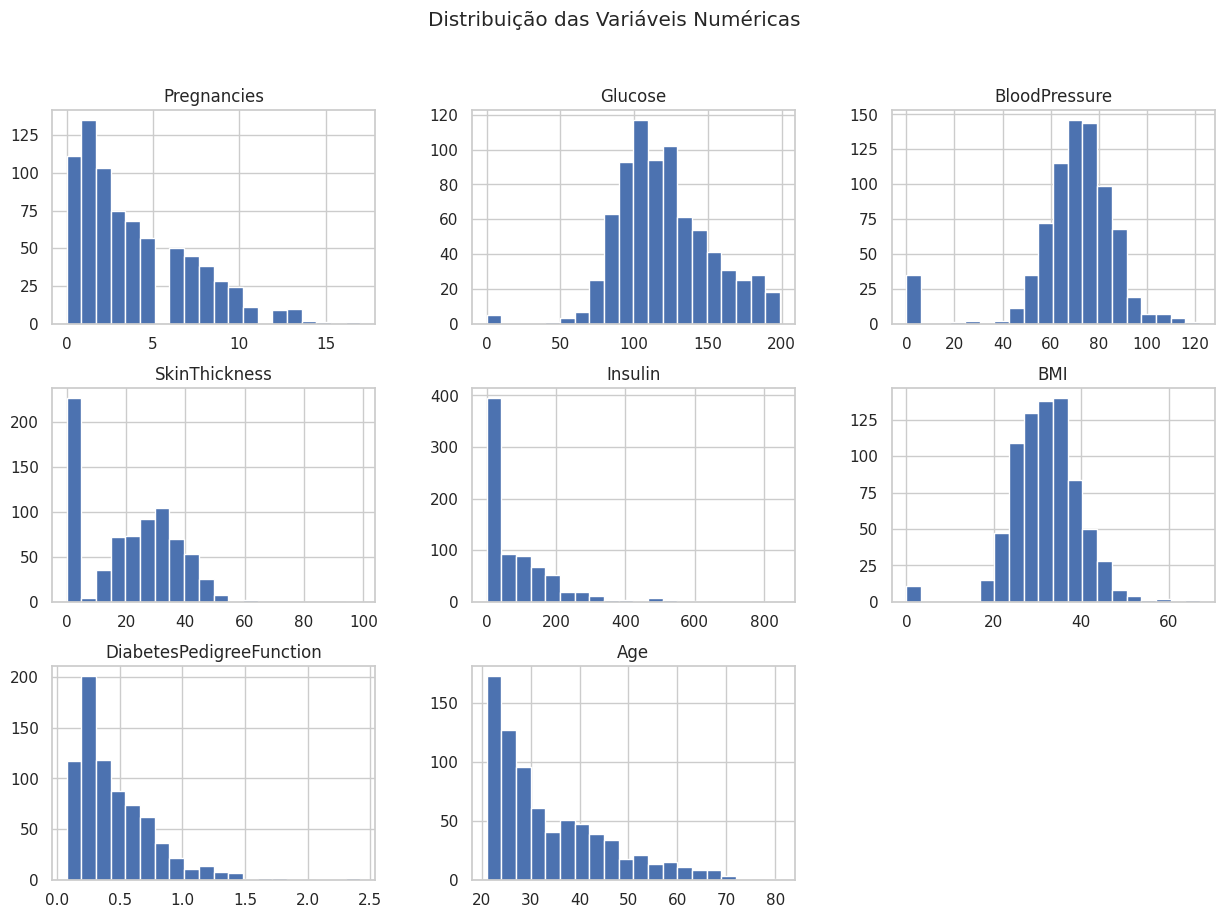

In [3]:
# Distribuição das classes
sns.countplot(x='Outcome', data=df)
plt.title('Distribuição das Classes (Outcome)')
plt.show()

# Estatísticas descritivas
print(df.describe())

# Heatmap de correlação
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Heatmap de Correlação entre os Atributos')
plt.show()

# Histogramas das variáveis numéricas
num_cols = df.columns.drop('Outcome')
df[num_cols].hist(bins=20, figsize=(15,10))
plt.suptitle('Distribuição das Variáveis Numéricas')
plt.show()

## 4. Pré-Processamento de Dados

Aqui realizamos o balanceamento das classes e a divisão dos dados em treino e teste.

In [4]:
# Balanceamento das classes (upsample da minoria)
df_majority = df[df.Outcome == 0]
df_minority = df[df.Outcome == 1]
df_minority_upsampled = df_minority.sample(n=len(df_majority), replace=True, random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

print(f"Após balanceamento: {df_balanced.Outcome.value_counts().to_dict()}")

# Separação em X e y
y = df_balanced['Outcome']
X = df_balanced.drop('Outcome', axis=1)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Após balanceamento: {0: 500, 1: 500}


## 5. Treinamento e Avaliação do Modelo

Treinamento do modelo Random Forest, relatório de classificação, matriz de confusão e validação cruzada.

In [5]:
# Treinamento do modelo
modelo = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=10, random_state=42)
modelo.fit(X_train, y_train)

# Avaliação no teste
y_pred = modelo.predict(X_test)
print("Relatório de Classificação (Teste):")
print(classification_report(y_test, y_pred))
print("Matriz de Confusão (Teste):")
print(confusion_matrix(y_test, y_pred))

# Validação cruzada
test_scores = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')
print(f"Acurácia média na validação cruzada (5-fold): {test_scores.mean():.3f} (+/- {test_scores.std():.3f})")

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        96
           1       0.88      0.91      0.90       104

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Matriz de Confusão (Teste):
[[83 13]
 [ 9 95]]
Acurácia média na validação cruzada (5-fold): 0.845 (+/- 0.027)


## 6. Visualização de Resultados

Gráficos de importância das features, curva ROC e outras visualizações para avaliação do modelo.

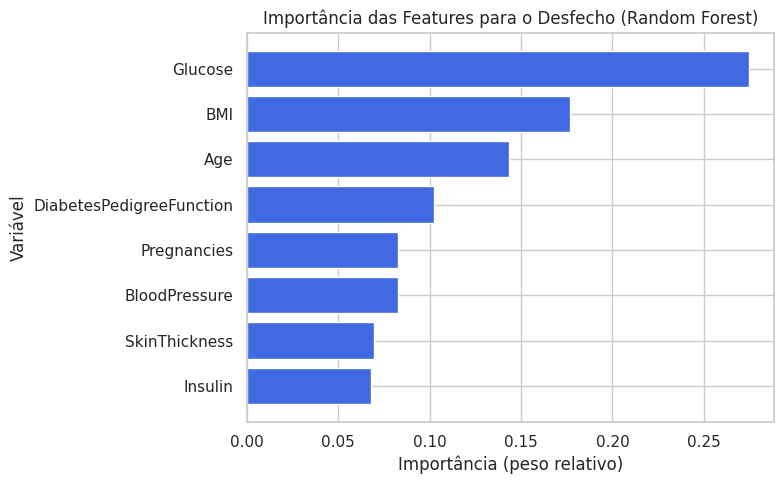

In [6]:
# Importância das features
importances = modelo.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh([X.columns[i] for i in indices], importances[indices], color='royalblue')
plt.title('Importância das Features para o Desfecho (Random Forest)')
plt.xlabel('Importância (peso relativo)')
plt.ylabel('Variável')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/tmp/ipykernel_45687/1265548893.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


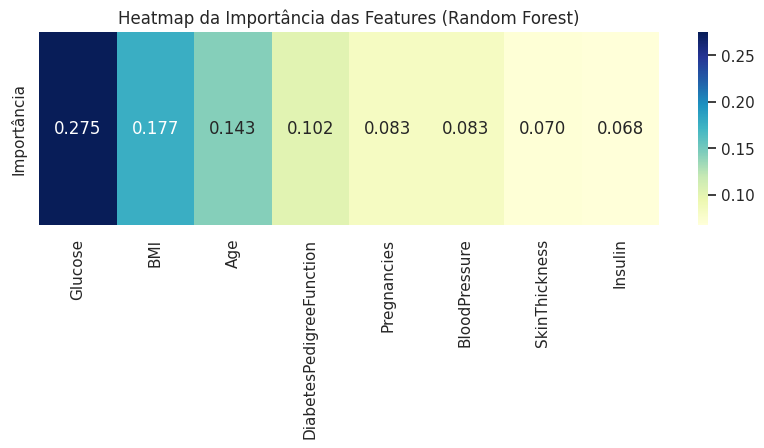

In [7]:
plt.figure(figsize=(10,2.5))
sns.heatmap([importances[indices]], annot=True, fmt='.3f', cmap='YlGnBu', cbar=True,
            xticklabels=[X.columns[i] for i in indices], yticklabels=['Importância'])
plt.title('Heatmap da Importância das Features (Random Forest)')
plt.tight_layout()
plt.show()

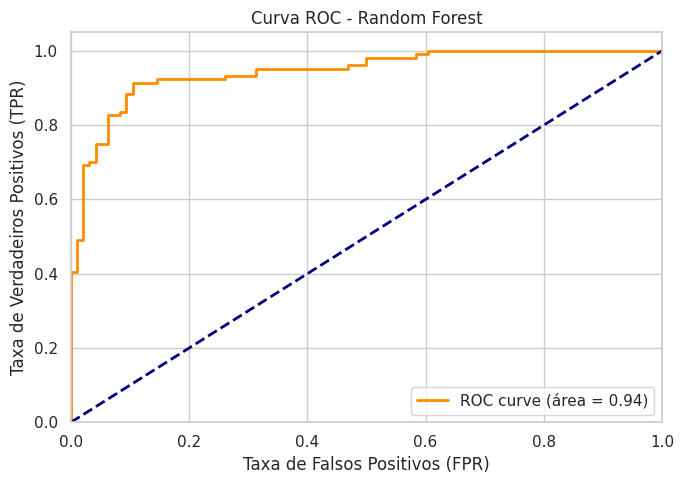

In [8]:
# Curva ROC
probs = modelo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 7. Considerações Finais

Este notebook concentrou toda a análise exploratória, visualização e avaliação do modelo de predição de diabetes. O script `treina_modelo.py` deve ser utilizado apenas para o treinamento e salvamento do modelo, enquanto este notebook serve para documentação, explicação e apresentação dos resultados para o TCC.

## 8. Boxplots: Distribuição das Variáveis por Classe (Outcome)

Os boxplots abaixo mostram a distribuição de cada variável numérica separada por classe (Outcome: 0 = não diabético, 1 = diabético). Isso ajuda a visualizar diferenças de mediana, dispersão e possíveis outliers entre os grupos.

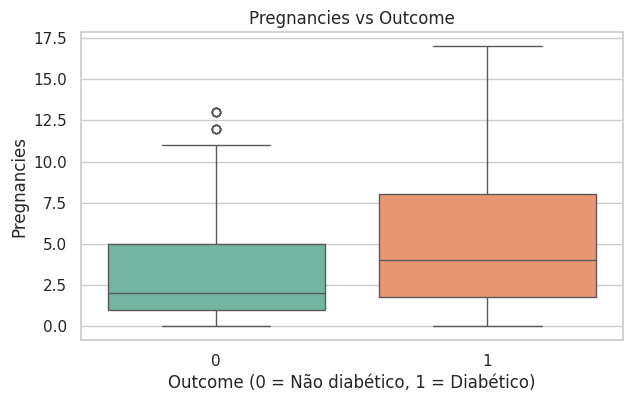

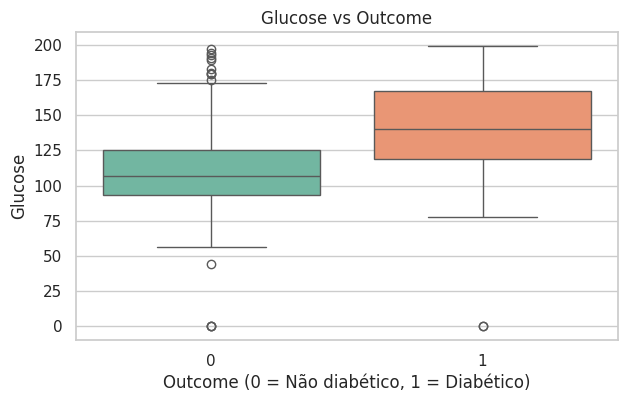

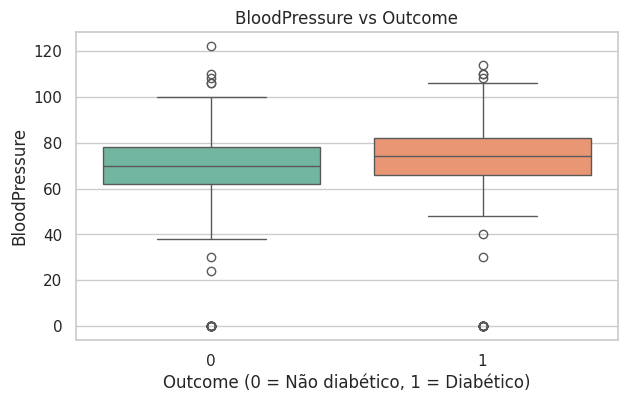

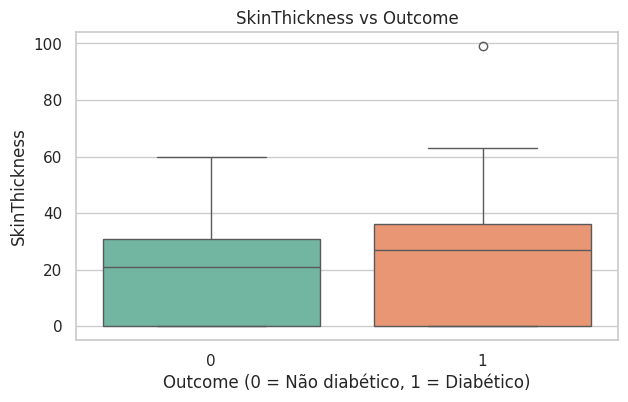

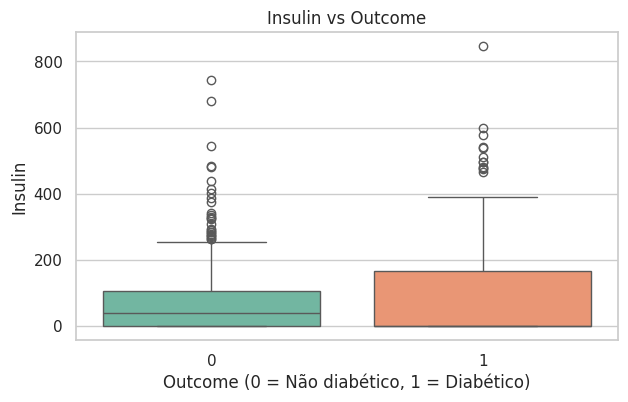

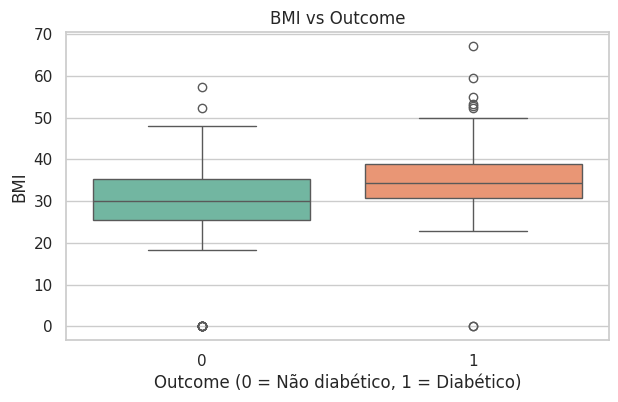

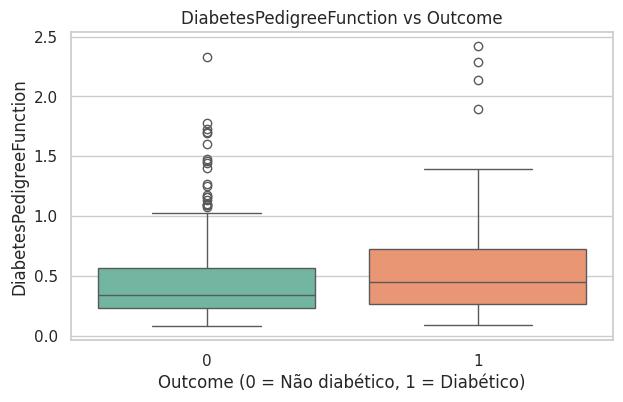

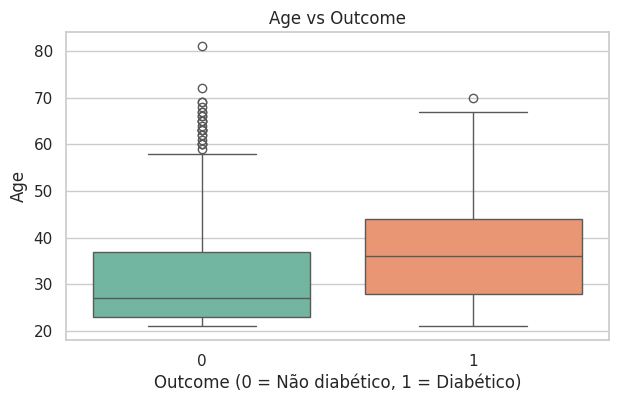

In [13]:
# Exibe boxplots individuais para cada variável numérica vs Outcome
num_cols = df.columns.drop('Outcome')
for col in num_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='Outcome', y=col, data=df, hue='Outcome', palette='Set2', legend=False)
    plt.title(f'{col} vs Outcome')
    plt.xlabel('Outcome (0 = Não diabético, 1 = Diabético)')
    plt.ylabel(col)
    plt.show()